In [351]:
#Importing libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pulp import *

In [352]:
#List of datasets
path = os.getcwd()
os.listdir(path)

['.ipynb_checkpoints',
 'capacity.xlsx',
 'demand.xlsx',
 'fixed_cost.xlsx',
 'freight_costs.xlsx',
 'total_costs.xlsx',
 'variable_costs.xlsx',
 'warehouse_network_optimization.ipynb']

In [383]:
#Reading the datasets
capacity = pd.read_excel('capacity.xlsx',index_col=0)
demand = pd.read_excel('demand.xlsx',index_col=1)
fixed_cost = pd.read_excel('fixed_cost.xlsx',index_col=0)
freight_costs = pd.read_excel('freight_costs.xlsx',index_col=0)
total_costs = pd.read_excel('total_costs.xlsx',index_col=0)
variable_costs = pd.read_excel('variable_costs.xlsx',index_col=0)

In [384]:
#Checking capacities
capacity

,Low,High
Capacity (kUnits/month),,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,3000


In [385]:
#Formatting demand dataset
demand = demand.drop(demand.columns[[0]],axis=1)
demand.columns = demand.iloc[0]
demand = demand.drop(index=demand.index[0], axis=0)
demand['Demand'] = demand['Demand']/1000
demand

(Units/month),Demand
USA,2800.0
Germany,90.0
Japan,1700.0
Brazil,145.0
India,160.0


In [386]:
country_list = demand.index.values.tolist()
country_list

['USA', 'Germany', 'Japan', 'Brazil', 'India']

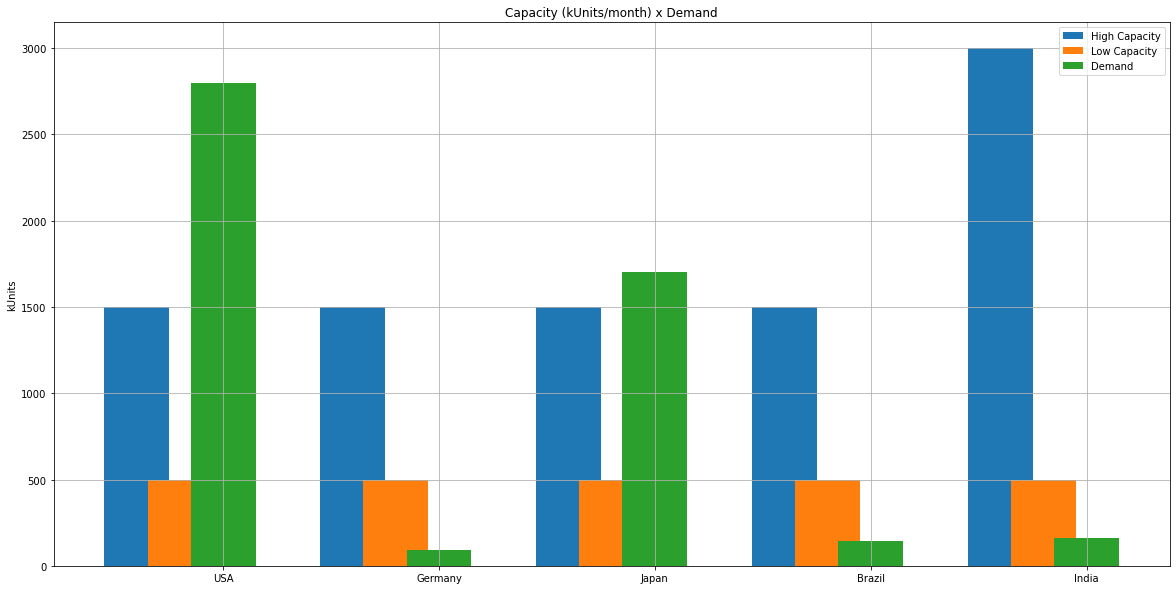

In [387]:
#Showing capacity graphs for exploratory analysis

plt.figure(figsize=(20,10))

width = 0.25

X_axis = np.arange(len(country_list))
  
plt.bar(X_axis - 0.4, capacity['High'], 0.3, label = 'High Capacity')
plt.bar(X_axis - 0.2, capacity['Low'], 0.3, label = 'Low Capacity')
plt.bar(X_axis + 0.0, demand['Demand'], 0.3, label = 'Demand')

plt.xticks(X_axis, country_list)
plt.ylabel("kUnits")
plt.title("Capacity (kUnits/month) x Demand")
plt.legend()
plt.grid()
plt.show()

In [388]:
#Returning demand to default
demand = pd.read_excel('demand.xlsx',index_col=1)
demand = demand.drop(demand.columns[[0]],axis=1)
demand.columns = demand.iloc[0]
demand = demand.drop(index=demand.index[0], axis=0)
demand

(Units/month),Demand
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [389]:
#Setting variable costs
#Each container has capacity to transport 1000 items
#So the cost of freight per unit is freight/1000

variable_costs = freight_costs/1000 + variable_costs
variable_costs = variable_costs.round(decimals = 2)
variable_costs


,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.00,24.25,13.10,28.10,20.78
Germany,26.34,13.00,21.62,33.24,23.07
Japan,25.40,32.75,10.00,53.61,24.35
Brazil,24.45,30.05,36.00,8.00,37.75
India,18.65,20.40,29.50,34.40,5.00


In [390]:
#Setting decision variables
localization = country_list
cap_size = ['Low','High']

In [393]:
#Inicializing model
model = LpProblem("Capacitated_Plant_Location_Model", LpMinimize)

In [394]:
#Creating decision variables lists with distributive method
x_dvariables = [(i,j) for i in localization for j in localization]
y_dvariables = [(i,j) for j in cap_size for i in localization]

#x_dvariables , y_dvariables

In [395]:
#Creating decision variables dictionnaries

'''
lowbound – The lower bound on these variables’ range. Default is negative infinity
upBound – The upper bound on these variables’ range. Default is positive infinity
cat – The category these variables are in, Integer or Continuous(default)
'''

x = LpVariable.dicts("production_", x_dvariables, lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", y_dvariables, cat='Binary')

In [396]:
#Creating lpSum variables for objetive function
fix_cost_variables = [fixed_cost.loc[i,j]*y[(i,j)]*1000 for j in cap_size for i in localization]
var_cost_variables = [variable_costs.loc[i,j]*x[(i,j)] for i in localization for j in localization]
#fix_cost_variables, var_cost_variables

In [397]:
#Defining objetive function

'''
def set_objective(self, variables, coefficients):
        self.prob += lpSum([variable * coefficient for variable]) 
'''

model += lpSum(fix_cost_variables) + lpSum(var_cost_variables)

In [398]:
#Setting the constraints
for j in localization:
    model += lpSum([x[(i,j)] for i in localization]) == demand.loc[j,'Demand']

for i in localization:
    model += lpSum([x[(i,j)] for j in localization]) <= lpSum([capacity.loc[i,s]*y[(i,s)]*1000 for s in cap_size])    

In [399]:
#Solve model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))

Total Costs = 92,981,000 ($/Month)

Status: Optimal


In [400]:
#Setting dictionnaries with plant size and production's capacity
dict_plant = {}
dict_prod = {}

#The value of dictionnary receives varValue of model variables

for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__','').replace('_','')
        dict_plant[name] = int(v.varValue) 
        p_name = name
    else:
        name = v.name.replace('production__','').replace('_','')
        dict_prod[name] = v.varValue
    print(name,"=",v.varValue)

('Brazil','High') = 0.0
('Brazil','Low') = 1.0
('Germany','High') = 0.0
('Germany','Low') = 0.0
('India','High') = 1.0
('India','Low') = 0.0
('Japan','High') = 1.0
('Japan','Low') = 0.0
('USA','High') = 1.0
('USA','Low') = 0.0
('Brazil','Brazil') = 145000.0
('Brazil','Germany') = 0.0
('Brazil','India') = 0.0
('Brazil','Japan') = 0.0
('Brazil','USA') = 0.0
('Germany','Brazil') = 0.0
('Germany','Germany') = 0.0
('Germany','India') = 0.0
('Germany','Japan') = 0.0
('Germany','USA') = 0.0
('India','Brazil') = 0.0
('India','Germany') = 90000.0
('India','India') = 160000.0
('India','Japan') = 0.0
('India','USA') = 1500000.0
('Japan','Brazil') = 0.0
('Japan','Germany') = 0.0
('Japan','India') = 0.0
('Japan','Japan') = 1500000.0
('Japan','USA') = 0.0
('USA','Brazil') = 0.0
('USA','Germany') = 0.0
('USA','India') = 0.0
('USA','Japan') = 200000.0
('USA','USA') = 1300000.0


In [404]:
#Capacity plant by optimal model

list_low, list_high = [],[]

for l in localization:
    for capacity in ['Low','High']:
        x = "('{}','{}')".format(l,capacity)
        if capacity == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
optimal_model_result = pd.DataFrame({'Location': localization, 'Low':list_low, 'High': list_high}).set_index('Location')
optimal_model_result

,Low,High
Location,,
USA,0,1
Germany,0,0
Japan,0,1
Brazil,1,0
India,0,1
